# Lab 2: Classifying DA and DS Job Descriptions

## Team Push-Pull

Son Tran, Bang Nguyen, Annie Pfeufer

Sunday, February 18, 2024


## Introduction

The data in this lab comes from GlassDoor.com which is a career community website where companies and their employees (past or current) can post reviews on the company or specific job positions. This website is commonly used in the job recruiting process, as it can help with the branding of a company, or prospective employees who are looking to learn more. The data that we are using in this lab, is a group of job descriptions that come up when searching GlassDoor.com for "data analytics" or "data science" listings. The metadata for these descriptions includes information such as the url it was scraped from, the company and job title associated with the description, when it was scraped from the web, and whether it came up under the "data analytics" or "data science" search terms. 

The purpose of our report is to come to an understanding of how jobs are labeled - under data analytics or data science. We want to know what features of a job description can be best used to predict whether a job comes up under a "data analytics" or "data science" search. 

The stakeholders in our analysis are GlassDoor.com and its users. This includes companies and employees who post to this website, as well as people who read postings to learn more about working at a certain place. These people are important to consider because this lab is analyzing the way in which the present their jobs as data analytics or data science postings. 

## Data Exploration


In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('GlassDoorMeta.csv')
df.head()

,Unnamed: 0,id,url,company,job_title,duplicates,first_date_scraped,latest_date_scraped,data_science,data_analytics
0,0,983,/partner/jobListing.htm?pos=213&ao=1110586&s=5...,First Financial Asset Management,Data Analytics Associate of Data Science,288,09-03-2022,09-11-2022,1,1
1,1,72,/partner/jobListing.htm?pos=203&ao=1110586&s=5...,John Deere,Part-Time Student-Data Analytics-Remote,280,09-03-2022,09-08-2022,1,1
2,2,1876,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,FrankCrum Staffing,Data Analytics Specialist,258,09-04-2022,09-12-2022,0,1
3,3,7186,/partner/jobListing.htm?pos=106&ao=1110586&s=5...,Vertex Pharmaceuticals,"Contractor, Data Analytics",246,09-07-2022,09-12-2022,1,1
4,4,976,/partner/jobListing.htm?pos=206&ao=1110586&s=5...,John Deere,Data Science & Analytics Development Program 2...,214,09-03-2022,09-12-2022,1,0


In [2]:
df.shape

(867, 10)

This table has data about 867 job listings and 9 variables about the job id, url of the job list, the listing company, title of the job, number of duplicates scraped, the first and last day the job was scraped and whether it's labeled as data science or data analytics. With every job id, there's one file of job description correlated to that job.

In order to predict the label that is given to the job, we consider that job description would be the best factor. Hence, we will only use `id` to get the correlated job description, the `data science` as the variable to be predicted as "1" indicates Data Science job and "0" indicates Data Anlytics. We will filter out all the observation labeled as both.

In [3]:
# Exclude rows marked as both "data analytics" and "data science" advertisements
filtered_df = df[~((df['data_science'] == 1) & (df['data_analytics'] == 1))]

# Display the first few rows of the filtered dataframe to confirm the exclusion
filtered_df.shape

(796, 10)

Our dataset gets down to 796 observations

In [3]:
# Count matches for each query
count_data_analytics = filtered_df['data_analytics'].sum()
count_data_science = filtered_df['data_science'].sum()

# Print the results
print(f"Jobs matching 'data analytics': {count_data_analytics}")
print(f"Jobs matching 'data science': {count_data_science}")

Jobs matching 'data analytics': 381
Jobs matching 'data science': 415


We have a quite even number for each job, which means one of them does not dominate the other. This is helpful for the building our models.

Now, we'll start by reading all the job descritions and append them into a dictionary. Then, we'll use TfidfVectorizer to transform them into vectors used to build our classifying models.

In [5]:
job_descriptions = []  # List to hold the content of each job description
ds_labels = []          # 1 for DS and 0 for DA

for i, row in filtered_df.iterrows():
    job_id = row['id']
    job_path = 'job_descriptions/' + str(job_id) + '.txt'
    with open(job_path, encoding="utf8") as file:
        job_description  = file.read()
        job_descriptions.append(job_description)
        ds_labels.append(row['data_science']) 

print(len(ds_labels))
assert len(job_descriptions) == len(ds_labels)

796


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Transform the documents into TF-IDF matrix
tfidf_descripstions = vectorizer.fit_transform(job_descriptions)
print(type(tfidf_descripstions[0]))


<class 'scipy.sparse._csr.csr_matrix'>


## Code & Results

This section should include numerous chunks of python code with helpful annotations (comments and/or brief markdown cells after each chunk). Remember to print or return all results in your notebook so they display in the html file you output for the assignment. 

For this assignment in particular, make sure you have clearly marked code chunks performing the following:

- Perform a train/test split 
- Train your logistic regression model on training data 
- Make predictions using the test set and assess model performance by discussing the accuracy score
- Analyze and interpret your logistic regression classifier's strongest term coefficients 
- Use code and/or visuals to demonstrate that none of your selected features are overly correlated with one another 
- Train and test a KNN model using the features your team selected
- Use code and/or visuals to demonstrate which variables mattered most to the KNN classifier

#### Train/test split

In [10]:
from sklearn.model_selection import train_test_split
# Perform a train/test split
X_train, X_test, ds_train, ds_test = train_test_split(tfidf_descripstions, ds_labels, test_size = 0.2,
                                                    random_state = 0)

#### Logistic classifier

In [11]:
from sklearn.linear_model import LogisticRegression
# Train logistic regression model on training data 
classifier_ds = LogisticRegression().fit(X_train, ds_train)
logistic_ds_pred = classifier_ds.predict(X_test) # Make predictions using the test set

Confusion Matrix:


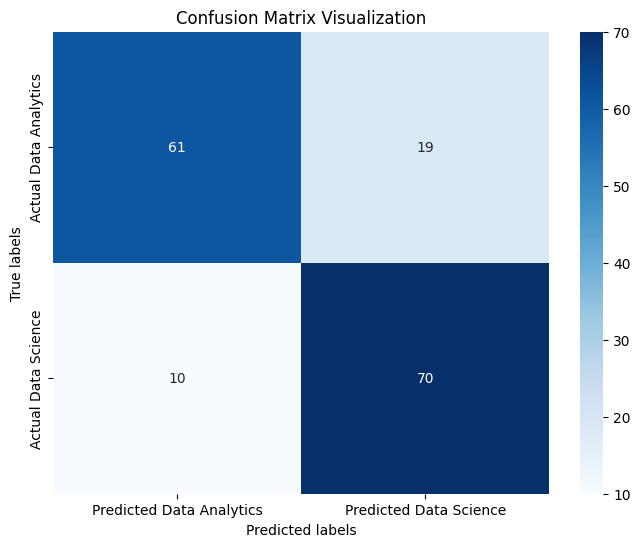

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81        80
           1       0.79      0.88      0.83        80

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.82      0.82      0.82       160



In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
# Assess model performance and accuracy confusion matrix
confusion_matrix = metrics.confusion_matrix(ds_test,logistic_ds_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=['Predicted Data Analytics', 'Predicted Data Science'],
            yticklabels=['Actual Data Analytics', 'Actual Data Science'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Visualization')
plt.show()
result1 = metrics.classification_report(ds_test,logistic_ds_pred)
print("Classification Report:",)
print (result1)

- 86% of the predicted Data Analytics jobs are actually Data Analytics jobs and 79% of predicted Data Science jobs are correctly predicted.

- 76% of the actual Data Analytics jobs are correctly predicted while it's 88% for actual Data Science jobs.

- Both f1-scores are close to 1, which indicates we have a quite good model.

- We have 80 of each job in the test dataset.

In [13]:
import numpy as np
# Analyze and interpret logistic regression classifier's strongest term coefficients
voc = vectorizer.vocabulary_
num_features = 10
ds_top_indices = np.argsort(classifier_ds.coef_,axis=1)[:,-num_features:]
da_top_indices = np.argsort(classifier_ds.coef_,axis=1)[:,:num_features]
inv_voc = {v: k for k, v in voc.items()}
ds = 'DS: '
for i in range(num_features):
    ds += inv_voc[ds_top_indices[0,i]]
    if i!=num_features:
        ds+=', '
print(ds)

print(80*'-')
da = 'DA: '
for i in range(num_features):
    da += inv_voc[da_top_indices[0,i]]
    if i!=num_features:
        da+=', '
print(da)

DS: ai, statistics, research, python, product, engineering, scientist, learning, machine, science, 
--------------------------------------------------------------------------------
DA: analytics, travelers, reporting, management, bi, power, google, analyst, excel, guidehouse, 


These are the words that have the top strongest and weakest coefficients in the model for Data Science. The weakest are the strongest for Data Analytics

Words like `AI`, `statistics`, `research`, and other words printed in the DS section above will increase the probability of a job to be predicted as Data Science.

With the same logic, job ads including `analytics`, `travelers`, `reporting`, `power BI`, `Excel` will likely to be predicted as Data Analytics


---

#### KNN model

We choose our feaatures according to their coefficient in the Logistic model. By doing this, we assume our Logistic model is a good model so that these features are credible.

In [24]:
# Select key features for KNN
ds_top_indices = np.argsort(classifier_ds.coef_,axis=1)[:,-5:]
da_top_indices = np.argsort(classifier_ds.coef_,axis=1)[:,:5]
selected_features = np.concatenate((np.squeeze(ds_top_indices), np.squeeze(da_top_indices)), axis=0).tolist()
selected_vocabs = []
for i in selected_features:
    selected_vocabs.append(inv_voc[i])
print("Original Train Set Shape:\t{}".format(X_train.shape))
new_X_train = X_train[:,selected_features]
new_X_test = X_test[:,selected_features]
print("KNN Train Set Shape:\t\t{}".format(new_X_train.shape))

Original Train Set Shape:	(636, 5000)
KNN Train Set Shape:		(636, 10)


(10, 636)


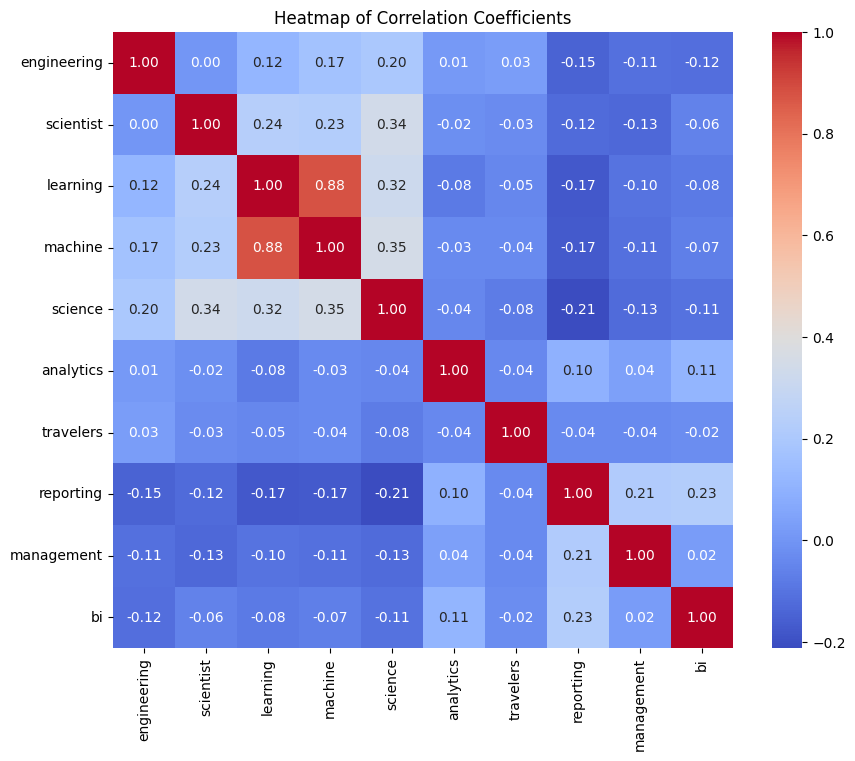

In [25]:
# Use code and/or visuals to demonstrate that none of your selected features are overly correlated with one another 
A = np.transpose(new_X_train.toarray())
print(A.shape)
corr_matrix = np.corrcoef(A)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=selected_vocabs,
            yticklabels=selected_vocabs)
plt.title('Heatmap of Correlation Coefficients')
plt.show()

It's clear from  the heatmap that except for `machine` and `learning`, all other features are slightly correlated. `Machine` and `learning` are highly correlated because they often come together as `machine learning`. We will drop one of the two features.

In [26]:
# Drop "machine learning" feature
drop_list = [voc['machine']]
print(drop_list)
selected_vocabs = list(set(selected_vocabs) - set(['machine']))
selected_features = list(set(selected_features) - set(drop_list))

[2729]


In [27]:
print("Original Train Set Shape:\t{}".format(X_train.shape))
new_X_train = X_train[:,selected_features]
new_X_test = X_test[:,selected_features]
print("KNN Train Set Shape:\t\t{}".format(new_X_train.shape))

Original Train Set Shape:	(636, 5000)
KNN Train Set Shape:		(636, 9)


(9, 636)


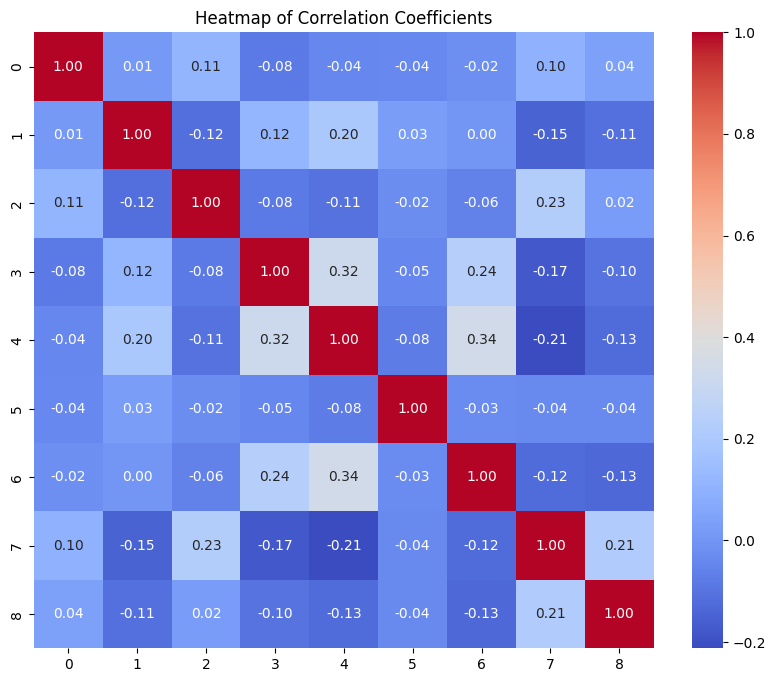

In [28]:
# Let's check for correlation again
A = np.transpose(new_X_train.toarray())
print(A.shape)
corr_matrix = np.corrcoef(A)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Coefficients')
plt.show()

Look much better. Now we're ready for KNN Classfier

Confusion Matrix:


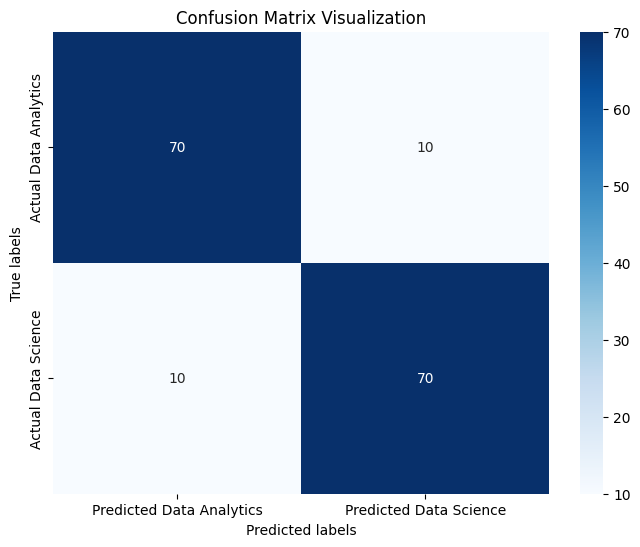

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        80
           1       0.88      0.88      0.88        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Train and test a KNN model using the features your team selected
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(new_X_train, ds_train)
knn_ds_pred = classifier.predict(new_X_test)
confusion_matrix = metrics.confusion_matrix(ds_test,knn_ds_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=['Predicted Data Analytics', 'Predicted Data Science'],
            yticklabels=['Actual Data Analytics', 'Actual Data Science'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Visualization')
plt.show()
result1 = metrics.classification_report(ds_test,knn_ds_pred)
print("Classification Report:",)
print (result1)

The performances of KNN Classifier on Data Analytics and Data Science are the same. 88% of the predicted are correct and 88% of actual are correctly predicted. F1-scores from this model are slightly closer to 1 than the Logistic model, which indicates they are slightly better.

In [41]:
# Use code and/or visuals to demonstrate which variables mattered most to the KNN classifier

knn_df = pd.DataFrame(new_X_train.toarray(), columns = selected_vocabs)
knn_df.describe()


,scientist,engineering,science,analytics,bi,learning,reporting,management,travelers
count,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000
mean,0.032467,0.018191,0.010681,0.021090,0.029503,0.003517,0.009810,0.014489,0.020357
std,0.037550,0.030311,0.031935,0.037432,0.036475,0.037734,0.029867,0.031626,0.027488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.020433,0.000000,0.000000,0.000000,0.018921,0.000000,0.000000,0.000000,0.011360
75%,0.046146,0.025636,0.000000,0.027617,0.042189,0.000000,0.000000,0.018490,0.031363
max,0.214341,0.214767,0.355415,0.355265,0.245400,0.523673,0.292270,0.257542,0.155691


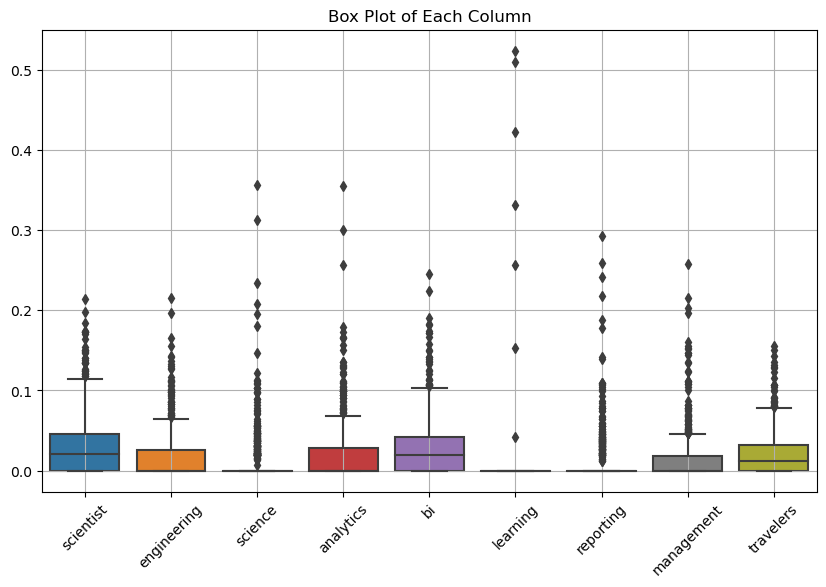

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=knn_df)
plt.xticks(rotation=45)
plt.title('Box Plot of Each Column')
plt.grid(True)
plt.show()

In the context of a KNN classifier, features with wider spreads and more outliers have more influence on the classification as KNN establishes based on the nearest neighbors. Therefore, features `learning`, `BI`, `analytics`, and `science` matter most to the KNN classifier. 

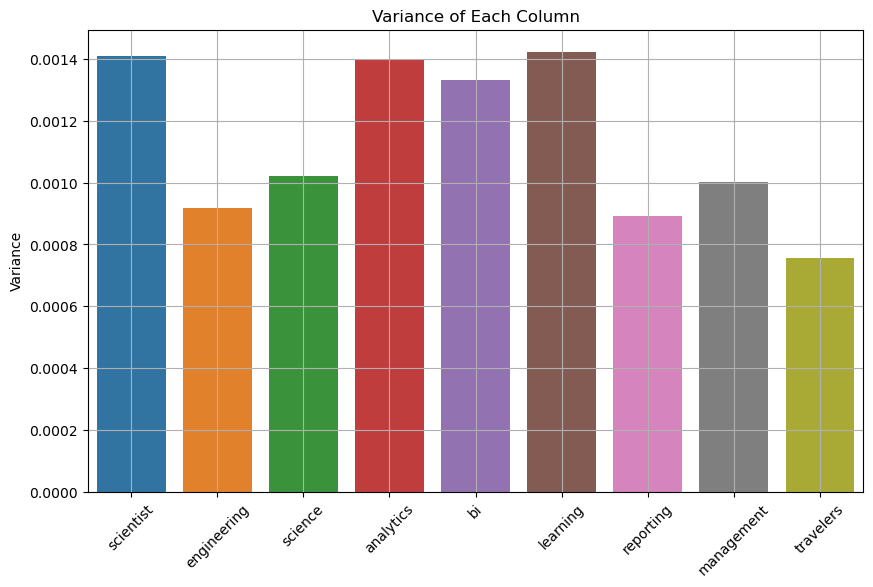

In [43]:
variance = knn_df.var()

plt.figure(figsize=(10, 6))
sns.barplot(x=variance.index, y=variance.values)
plt.xticks(rotation=45)
plt.title('Variance of Each Column')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

__Model Differences__: 

KNN seems to show less volatile in its prediction, which means it performs similarly on both sides, but it's harder to decide the strength of different features on the model while Logistic varies in its prediction and gives coefficient to show the how impactful its features are. 

## Conclusion

For our analysis, we performed a tf_idf analysis on the body of job descriptions to find the most commonly used unique words in each job description, and created a list of binary values denoting whether the job description was found under "data science" or not (not would imply it was found under "data analytics"). We then split the corresponding job description term-scores, and items in the list, to have some of the data to train a logistic classifier model on, and some to test our model on. From this, we found that based on a logistic regression, we could get a fairly accurate model of predicting wheter a job was classified as data analytics or data science. We then found specific words that had strong coefficients for data science or data analytics so that we could run a KNN model using only these words. We then trained our model and tested it the same way that we trained and tested our logistic model, and fount the KNN model to be slightly better. 

The strenghts of running this method are that our model was fairly accurate, especially the KNN model, in predicting whether a job description would come up under data analytics or data science search terms, however it did not account for any of the job descriptions that came up under both searches. The dataset included descritions that appeared under both searches, but for our analysis we took these out. This was because we were aiming to classify the descriptions as either data science or data analytics, not both. In future analysis, this is something that we could try to incorperate into our models. 

## References      

List all works cited and consulted. Use proper APA format. (Note that this assignment does not require outside sources, but all sources you draw upon must be given proper credit.)